# Estimating the energy of a low frequency signal with low-pass filtering

We are interested in computing the energy of a variable $u$ which because it may coexist with higher frequency motions need to be low-pass filtered (filtered variable is denoted $\bar u$).
The energy of the low-frequency signal is then estimated to be:

$
\begin{align}
E &= \big \langle \bar u^2 \big \rangle
\end{align}
$

- Figure: sensitbilité (biais, variance) à la fréquence de coupure du filtre pass-bas vs échelle de temps de décorrelation du signal
- Figure: sensibilité à la quantité de données disponibles
- Figure: sensibilité au sous-sampling (variance préservée)

### references (!to be updated!):

- Bendat and Piersol: *J. S. Bendat and A. G. Piersol. Random Data: Analysis and Measurement Procedures. Wiley series in probability and statistics. Wiley-Interscience, 3rd edition, 2000.*
- Bailey and Hammersley 1946 - general timeseries, sample mean and variance : *G. Bayley and J. Hammersley. The” effective” number of independent observations in an autocorrelated time series. Supplement to the Journal of the Royal Statistical Society, 8(2):184–197, 1946.*
- Zieba 2010: *A. Zieba. Effective number of observations and unbiased estimators of variance for autocorrelated data-an overview. Metrology and Measurement Systems, (1), 2010.*
- Barlett 1946 - long time series, autocorrelations: *M. S. Bartlett. On the theoretical specification and sampling properties of autocorrelated time-series. Supplement to the Journal of the Royal Statistical Society, 8(1):27–41, 1946.*
- Chelton 1983 - multivariate case, cross-correlations: *D. B. Chelton. Effects of sampling errors in statistical estimation. Deep Sea Research Part A. Oceano- graphic Research Papers, 30(10):1083–1103, 1983.*

---
## generate synthetic data

Generate a 100 day time series with an exponential autocorrelation and a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from scipy import stats                                                         

import matplotlib.pyplot as plt
import seaborn as sns

import sstats.tseries as ts
import sstats.sigp as sigp
import sstats.hfreq as hf

# dev
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# https://www.wrighters.io/using-autoreload-to-speed-up-ipython-and-jupyter-work/
%reload_ext autoreload
%autoreload 1
#%aimport sstats
%aimport sstats

In [33]:
# total number of points
#N = ds.time.size # = delta_T/dt 

#effective_DOF(sigma, dt, N)
#print("mean - DOF (Neff):")
#print(f"  exact: {Neff_exact:.1f}")

---
## filter properties

In [41]:
filter_h, filter_t = {},{}
h_hat, w = {},{}
for filt_cut in filter_cutoff:
    filter_h[str(filt_cut)], filter_t[str(filt_cut)] = sigp.lowpass_filter(filt_cut, filter_size_pts, dt)
    h_hat[str(filt_cut)], w[str(filt_cut)] = sigp.filter_response(filter_h[str(filt_cut)], dt)

NameError: name 'filter_size_pts' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


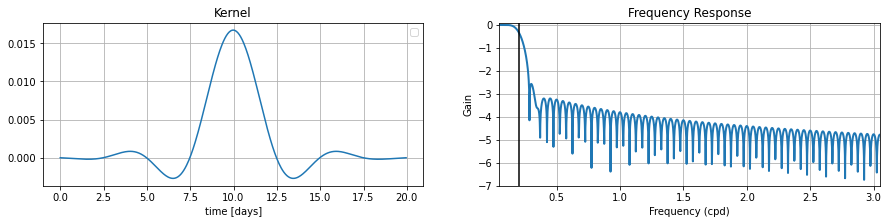

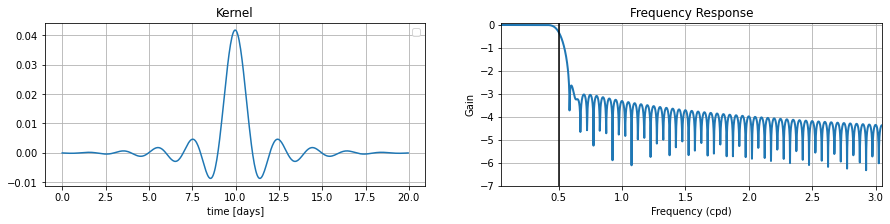

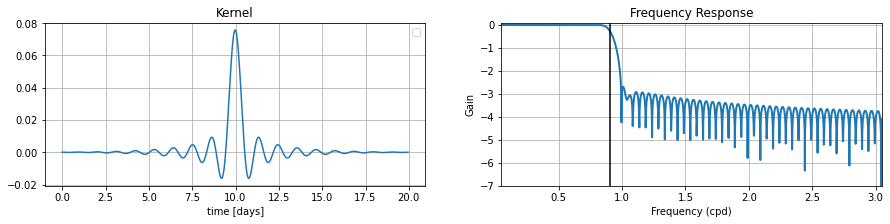

In [5]:
for filt in filter_h.keys():
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    ax.plot(filter_t[filt], filter_h[filt])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()

    ax = axes[1]
    ax.plot(w[filt], np.log10(abs(h_hat[filt])), linewidth=2)
    ax.axvline(float(filt), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
#    fig.savefig('/Users/zcaspar/Documents/Figures_methodo/lpass_filt_%s.pdf'%str(np.around(float(filt),decimals=2)))

---

## filter timer series and look at an overview

In [2]:
ds = xr.open_dataset('/Users/zcaspar/codes/mit4320/ds_synthetic_lf.nc')
ds

<xarray.Dataset>
Dimensions:  (T: 3, time: 7200, draw: 500, filt: 3)
Coordinates:
  * T        (T) float64 2.0 20.0 200.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * filt     (filt) int64 0 1 2
Data variables:
    u        (filt, T, time, draw) float64 ...
    u_bar    (filt, T, draw, time) float64 ...

In [3]:
T = 10

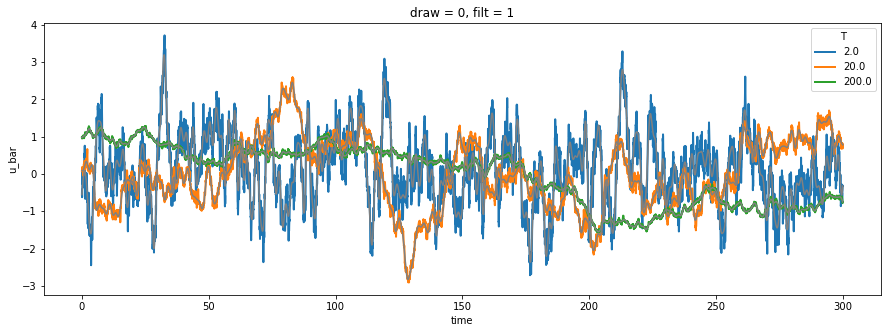

In [7]:
_ds = ds.sel(draw=0, filt=1, method="nearest")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.u.plot.line(x="time", lw=2)
_ds.u_bar.plot.line(x="time", color="0.5", add_legend=False)

In [10]:
ds.filt

<xarray.DataArray 'filt' (filt: 3)>
array([0, 1, 2])
Coordinates:
  * filt     (filt) int64 0 1 2

In [ ]:

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    for Tt in _ds['T']:
        x = _ds.sel(filt=k,T=Tt)#.values
        f, psd = welch(x.u.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax.loglog(f,psd,label='T = %s'%Tt.values)
        f, psd = welch(x.u_bar.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax.loglog(f,psd,c='grey')
        ax.grid();ax.legend();
        

In [90]:
import matplotlib as mpl
mpl.rcParams["font.size"]=13

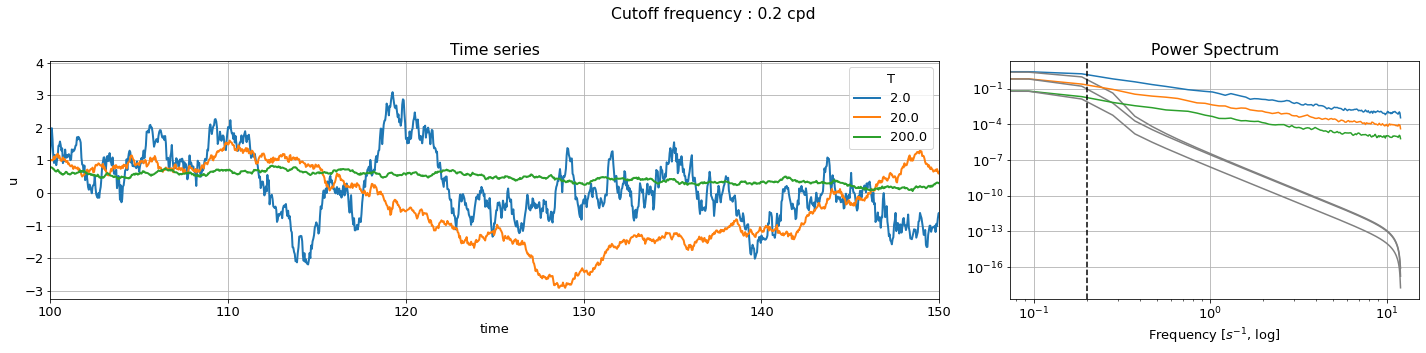

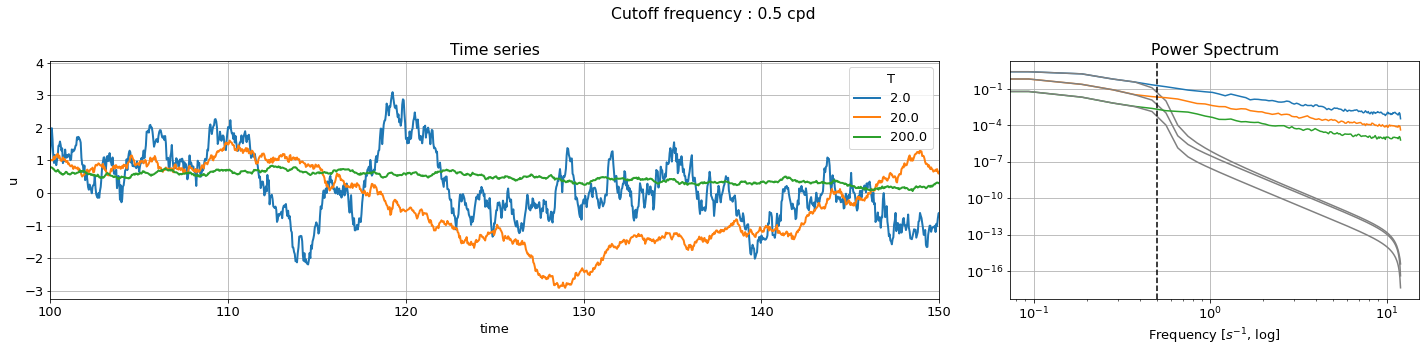

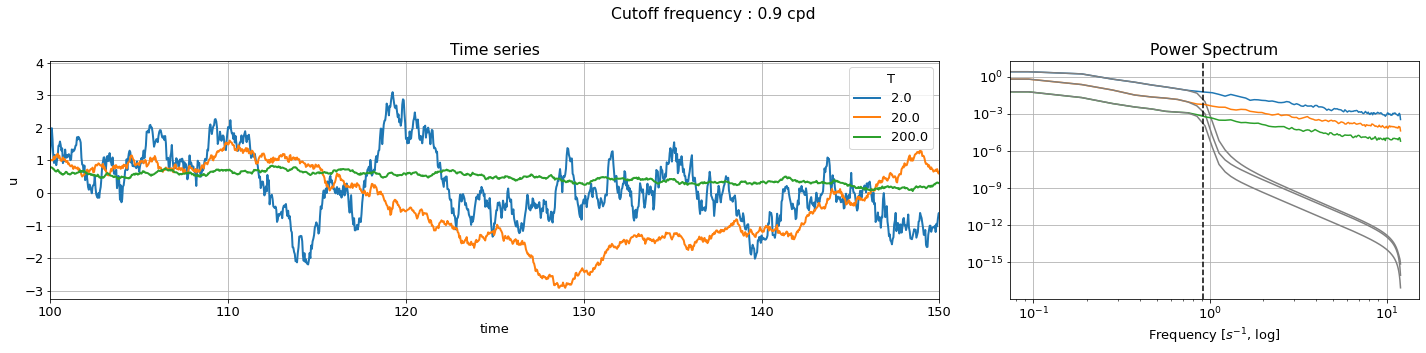

In [104]:
filter_cutoff = [1/5,1/2,1/1.1]
for k in ds.filt.values:
    _ds = ds.sel(draw=0, method="nearest")
    t = _ds.time.values
    fig = plt.figure(figsize=(20,5))
    spec = fig.add_gridspec(ncols=6,nrows=1)
    ax0 = fig.add_subplot(spec[:4])#axs[0]
    
#    for Tt in _ds['T']:
    _ds.sel(filt=k).u.plot.line(x="time", lw=2,ax=ax0)
#    x.u_bar.plot.line(x="time", color="0.5", add_legend=False,ax=ax0)
    ax0.set_xlim(100,150);ax0.grid();ax0.set_title('Time series');
    ax1 = fig.add_subplot(spec[4:])#axs[0]
    for Tt in _ds['T']:
        x = _ds.sel(filt=k,T=Tt)#.values
        f, psd = welch(x.u.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax1.loglog(f,psd)
        f, psd = welch(x.u_bar.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax1.loglog(f,psd,c='grey');
    ax1.grid();ax1.set_xlabel(r'Frequency [$s^{-1}$, log]')
    ax1.set_title('Power Spectrum');ax1.axvline(filter_cutoff[k],c='k',ls='--')
    fig.suptitle('Cutoff frequency : %s cpd'%str(np.around(filter_cutoff[k],decimals=1)))
    fig.tight_layout()
    fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lpass_filt_'+str(np.around(filter_cutoff[k],decimals=1))+'.png')

In [101]:
filter_cutoff[k]

0.9090909090909091

In [63]:
_ds = ds.sel(draw=0, method="nearest")

In [64]:
from scipy.signal import welch

f, psd = welch(x,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean

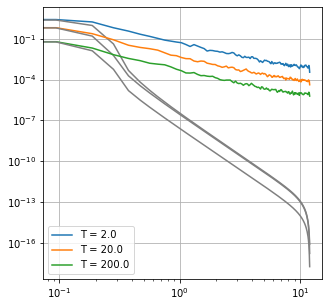

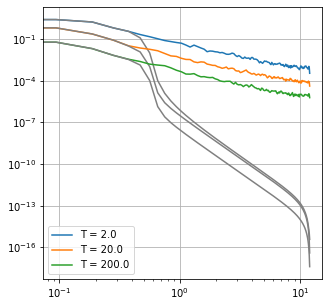

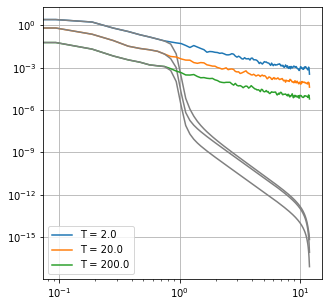

In [72]:
for k in _ds.filt.values:
    t = _ds.time.values
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    for Tt in _ds['T']:
        x = _ds.sel(filt=k,T=Tt)#.values
        f, psd = welch(x.u.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax.loglog(f,psd,label='T = %s'%Tt.values)
        f, psd = welch(x.u_bar.values,
               fs=1./(t[1]-t[0]),  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant')
        ax.loglog(f,psd,c='grey')
        ax.grid();ax.legend();
        

In [66]:
x

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (time: 7200)
Coordinates:
    T        float64 2.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
    draw     int64 0
    filt     int64 0
Data variables:
    u        (time) float64 ...
    u_bar    (time) float64 ...>

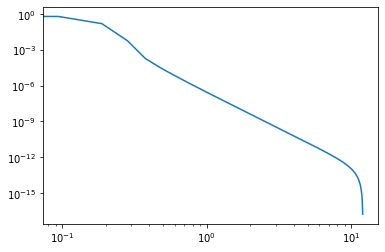

In [60]:
plt.loglog(f,psd)

---

## compute the energy (mean square value) of the filtered time series

In [18]:
#n_draws = 1000 # number of draws
#ds = generate_timeseries(delta_T, n_draws, T_all)

E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")]).compute()

(5, 0, 48000)(5, 0, 48000) (480,)
 (480,)
(5, 0, 48000) (480,)

In [19]:
E.u_bar.mean('draw').sel(T=100)

KeyError: 100.0

In [13]:
filter_h.keys()

dict_keys(['0.2', '0.5', '0.9090909090909091'])

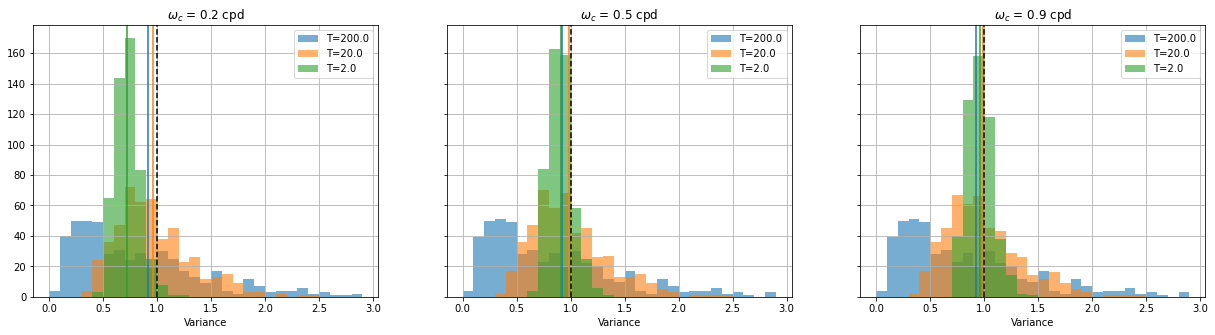

In [25]:
fig, axs = plt.subplots(1,E.filt.size, figsize=(7*E.filt.size,5),sharey=True)
bins = np.arange(0,3,.1)
for ax,j,f in zip(axs,E.filt,filter_cutoff):
    for _T, i in zip(ds.T[::-1],range(len(ds.T))):
        _da = E["u_bar"].sel(T=_T,filt=j)
        _da.plot.hist(ax=ax,bins=bins, alpha=0.6, label=f"T={float(_T)}")
        ax.axvline(_da.mean(), color=f"C{i}")
    ax.legend();ax.set_xlabel('Variance')
    ax.set_title(r'$\omega_c$ = %s cpd'%(np.around(float(f),decimals=1)))
    ax.grid();ax.axvline(1,c='k',linestyle='--')
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lpass_estimates_distrib.pdf')

---

## focus on bias and sensitivity to cutoff/decorrelation timescale ratio

A bit of theory first



In [43]:
from sympy import Symbol, pi, atan, factor, lambdify

In [44]:
u_low = hf.low_frequency_signal()

In [45]:
omegac = Symbol('omega_c', positive=True)
T_sp, U_sp = u_low.p['T'], u_low.p['U']
omega_sp, tau_sp = u_low.omega, u_low.tau

In [49]:
u_low.spectrum


2*T*U**2/(T**2*omega**2 + 1)

In [30]:
u_low.spectrum.integrate

<bound method Expr.integrate of 2*T*U**2/(T**2*omega**2 + 1)>

In [33]:
dt = 1/24
om = 2*np.pi*np.arange(0,40/dt)

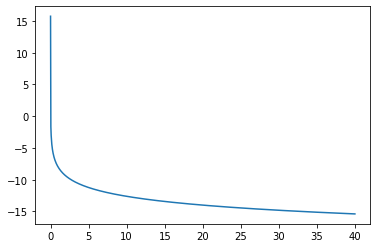

In [34]:
plt.plot(om/(2*np.pi)*dt,np.log(2*40/dt*3600*1/((40/dt*om)**2+1)))

In [35]:
I_low = u_low.spectrum.integrate((omega_sp, 0, omegac)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U_sp, T_sp, omegac], I_low)
I_low

2*U**2*atan(T*omega_c)/pi

In [36]:
E_low

<function _lambdifygenerated(U, T, omega_c)>

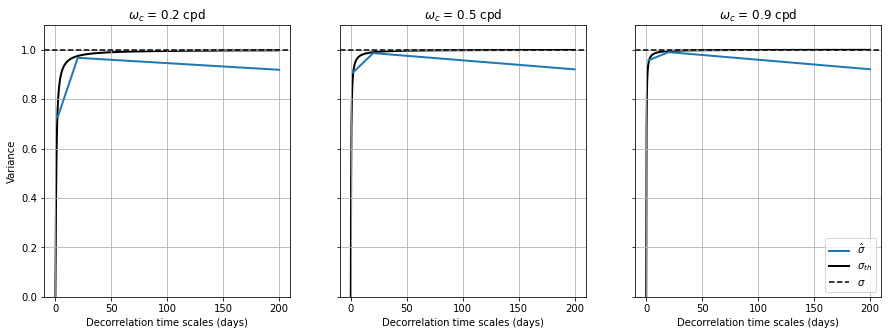

In [39]:
E["u_bar_mean"] = E.u_bar.mean("draw")
sigma0=1

fig, axs = plt.subplots(1,len(filter_cutoff), figsize=(5*len(filter_cutoff),5),sharey=True)

for i,k in enumerate(filter_cutoff):
#ds.E_ubar_theoretical.plot()
    E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), ds.T, filter_cutoff[i]*2*np.pi)
    E.u_bar_mean.sel(filt=i).plot(lw=2,ax=axs[i],label=r'$\hat{\sigma}$')
#ds.E_ubar_mean.plot.bar()

    # more finely resolved theoretical curve
    _T = np.arange(0, float(ds.T.max()),.1)
    _E = E_low(np.sqrt(sigma0), _T, filter_cutoff[i]*2*np.pi)
    axs[i].plot(_T,_E, lw=2, color="k", zorder=-1,label=r'$\sigma_{th}$')
    axs[i].axhline(np.sqrt(sigma0),linestyle='--', c='k',label=r'$\sigma$')
    axs[i].set_title(r'$\omega_c$ = %s cpd'%np.around(float(k),decimals=1))
    axs[i].set_ylim(0., 1.1);axs[i].set_xlabel('Decorrelation time scales (days)')
    axs[i].grid();axs[i].set_ylabel('')
axs[-1].legend()
axs[0].set_ylabel('Variance')
fig.savefig('/Users/zcaspar/Documents/Figures_manuscript/lpass_estimates_th.pdf')

In [22]:
E.u_bar.sel(filt=1)

<xarray.DataArray 'u_bar' (T: 3, draw: 500)>
array([[0.82976802, 0.82464198, 0.81446391, ..., 0.91090759, 0.72093835,
        0.82924037],
       [0.76288973, 1.15534607, 1.19033933, ..., 1.39098912, 0.99414615,
        1.21454083],
       [0.77427732, 0.47795186, 0.51653093, ..., 0.28029866, 0.86273876,
        0.47965898]])
Coordinates:
  * T        (T) float64 1.0 10.0 100.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
    filt     int64 1

### Confidence intervals

---

Assuming the time series are normally distributed, the energy will follow a chi square distribution (potentially non-centered):

$
\begin{align}
\frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2)
\end{align}
$

where $N$ is the effective degrees of freedom for the variance.
So the pdf of the energy $E$ is :

$
\begin{align}
p_E(x) = \frac{N}{E} p_\chi(x\times N/E),
\end{align}
$

and the following confidence interval can be employed:

$
\begin{align}
%q_{\alpha/2} < \frac{N x \hat E}{E}  = \chi^2(N, N \mu^2/\sigma^2), \\
\hat E \times \frac{N}{q_{1-\alpha/2}} < E < \hat E \times \frac{N}{q_{\alpha/2}},
\end{align}
$

where $q_\alpha$ is the $\alpha$ percentile of the $\chi^2$ distribution.

https://fr.wikipedia.org/wiki/Loi_du_%CF%87%C2%B2_non_centr%C3%A9e
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ncx2.html

for different number of points and one timescale.

regenerate dataset

In [23]:
import seaborn as sns
#sns.set_theme(style="whitegrid")

In [80]:
_ds = ds.sel(filt=1)
_E = E.sel(filt=1)
E_pdf_expected = lambda x, Ne, sigma0: Ne/sigma0*stats.ncx2.pdf(x*Ne/sigma0, Ne-1, Ne*mu**2/sigma0)

# compute effective degrees of freedom
N = _ds.u.time.size
def compute_Ne(T):
    L = []
    for t in T:
        c = lambda tau, t=t: sigma0*np.exp(-np.abs(tau/t))
        L.append(list(sigp.effective_DOF(c, dt, N)))
    Ne_mean, Ne_variance, _ = zip(*L)
    return list(Ne_mean), list(Ne_variance)

_N = compute_Ne(_E.T.values)

_E["Ne_mean"] = ("T", _N[0])
_E["Ne_variance"] = ("T", _N[1])

In [31]:
_ds.u.time.size

2400

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


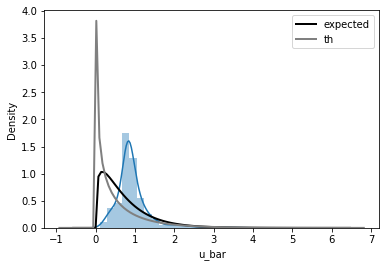

In [28]:
E_ = _E.sel(T=100.)

ax = sns.distplot(_E.u_bar, bins=30, norm_hist=True)

def add_dist(Ne, label, color):
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), sigma0)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)                                                     

add_dist(E_.Ne_variance, "expected", "black")
add_dist(E_.Ne_mean, "th", "0.5")

ax.legend()
#ax.set_ylim(0, 1.)

In [26]:
E_.Ne_variance

<xarray.DataArray 'Ne_variance' ()>
array(3.59821357)
Coordinates:
    T        float64 100.0
    filt     int64 1

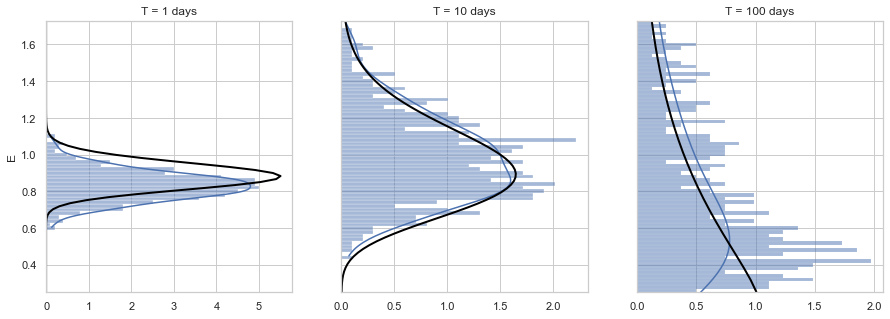

In [41]:
def add_dist(Ne, sigma0, label, color, ax):
    x0, x1 = ax.get_ylim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = E_pdf_expected(x_pdf, float(Ne), float(sigma0))
    ax.plot(y_pdf, x_pdf, color=color, lw=2, label=label)
    #ax.plot(x-y_pdf, x_pdf, color=color, lw=2, label=label)

bins = np.arange(.25, 1.75, .02)

fig, axes = plt.subplots(1, E.T.size, figsize=(15,5))

for _T, ax in zip(E.T, axes):
    E_ = _E.sel(T=_T)
    ax = sns.histplot(y=E_.u_bar, stat="density", bins=bins, kde=True, ax=ax)
    add_dist(E_.Ne_variance, E_.u_bar_theoretical, "expected", "black", ax)
    ax.set_title(f"T = {float(_T):.0f} days")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_ylim(bins[0], bins[-1])
    if ax!=axes[0]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("E")

In [83]:
alpha=0.1

#_Ne = E["Ne_mean"] # leads to an overestimate of the CI
_Ne = _E["Ne_variance"] # about right
_E["u_bar_low_delta"] =  _Ne/stats.ncx2.ppf(1-alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])
_E["u_bar_high_delta"] = _Ne /stats.ncx2.ppf(alpha/2, _Ne, _Ne*mu**2/E["u_bar_theoretical"])

Text(0.5, 1.0, 'CI hit rate')

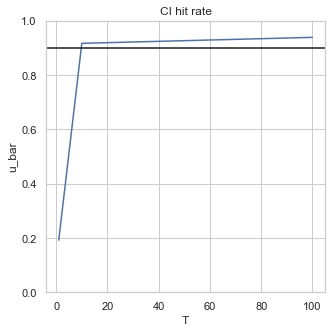

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

dum = _E.u_bar.where( (_E.u_bar * _E.u_bar_low_delta < _E.u_bar_theoretical) 
                    & (_E.u_bar * _E.u_bar_high_delta > _E.u_bar_theoretical) 
                   )*0+1
dum = dum.fillna(0.).mean("draw")
dum.plot()
ax.axhline(1-alpha, color="k")
ax.set_ylim(0,1)
ax.set_title("CI hit rate") # i.e. number of times the true value is within the CI

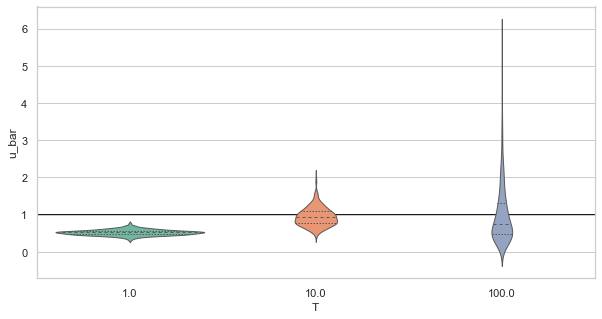

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["u_bar"].sel(filt=0).to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="u_bar",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

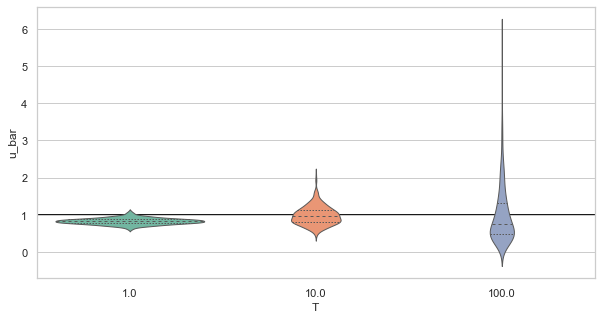

In [46]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["u_bar"].sel(filt=1).to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="u_bar",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

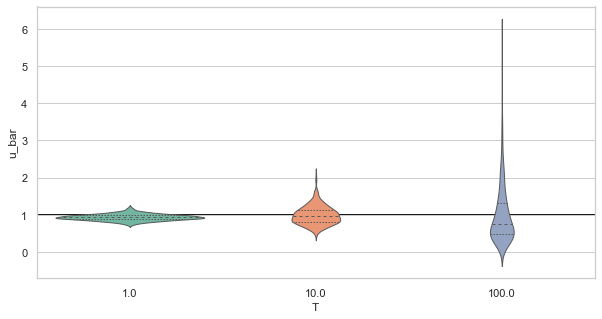

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

df = E["u_bar"].sel(filt=2).to_dataframe().reset_index()
sns.violinplot(data=df, x="T", y="u_bar",
               inner="quart", linewidth=1,
               palette="Set2",
               #palette={"Yes": "b", "No": ".85"})
                #label=f"T={float(_T)}"
               alpha=0.8
              )
ax = ax.axhline(1., lw=2, color="k", zorder=-1)

#sns.despine(left=True)

---

## sensibility to subsampling

For one decorrelation timescale (10 days) and fixed data quantity (200 days), data is decimated temporally.
Statistical variablity of the energy estimate is quantified and monitored as subsampling interval is increased.


In [81]:
delta_T = 200 # time series length in days
n_draws = 10000 # number of draws
ds = generate_timeseries(delta_T, n_draws, T,filter_h['0.5']).persist()

In [85]:
filter_cutoff

0.5

In [86]:
delta = [1,6,12,24,30,24*2,24*4,24*10,24*20,24*30,24*40]
delta_days = np.array(delta)*dt
#filter_cutoff =filter_cutoff[1]
c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def get_E(ds):
    E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")])

    dt = float(ds.time[1] - ds.time[0])
    N = ds.time.size
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    
    E["Ne_mean"]  = Ne_mean
    E["Ne_variance"]  = Ne_variance

    return E

E = xr.concat([get_E(ds.isel(time=slice(0,None,d))) for d in delta], "delta")
E = E.assign_coords(delta=delta_days).compute()

E["u_bar_theoretical"] = E_low(np.sqrt(sigma0), T, filter_cutoff*2*np.pi)
E["u_bar_low"] =  (E["u_bar_theoretical"]/E.Ne_variance 
                   *stats.ncx2.ppf(alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                  )
E["u_bar_high"] =  (E["u_bar_theoretical"]/E.Ne_variance
                   *stats.ncx2.ppf(1-alpha/2, E.Ne_variance, E.Ne_variance*mu**2/E["u_bar_theoretical"])
                   )

#E

Text(0, 0.5, 'energy')

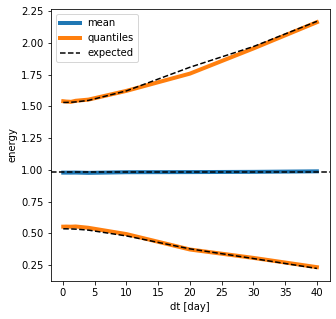

In [87]:
Eq = E.u_bar.quantile([alpha/2,1-alpha/2],"draw")

fig, ax = plt.subplots(1, 1, figsize=(5,5))

E.u_bar.mean("draw").plot(lw=4, label="mean")
Eq.isel(quantile=0).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=f"quantiles")
Eq.isel(quantile=1).plot.line(x="delta", color="C1", lw=4, add_legend=False, label=None)

ax.axhline(E.u_bar_theoretical, color="k", ls="--", label="expected")
E.u_bar_low.plot(color="k", ls="--")
E.u_bar_high.plot(color="k", ls="--")

ax.legend()
ax.set_title("")
ax.set_xlabel("dt [day]")
ax.set_ylabel("energy")

For sampling interval less than a 1/10 of the decorrelation length scale, there is no substantial increase of statistical variability

---
## expected interval in quantiles in (time interval , time step) space

In [114]:
ds = xr.Dataset(dict(alpha=np.geomspace(1e-5, 1e2, num=100), # time sampling: dt/T
                     beta=np.geomspace(1, 1e3, num=100)), # Time interval: delta_T / T
               )

ds["dt"] = T*ds.alpha
ds["N"] = (T*ds.beta/ds.dt).astype(int)

In [98]:
T

10

In [115]:
c = lambda tau: sigma0*np.exp(-np.abs(tau/T))

def compute_Ne(dt, N, estimate="variance"):
    if np.isnan(N):
        return np.NaN
    Ne_mean, Ne_variance, _ = sigp.effective_DOF(c, dt, N)
    if estimate=="variance":
        return Ne_variance
    elif estimate=="mean":
        return Ne_mean
    
ds["Ne"] = xr.apply_ufunc(compute_Ne, ds.dt, ds.N, vectorize=True)

ds["low"] = 1/ds.Ne*stats.ncx2.ppf(alpha/2, ds.Ne, ds.Ne*mu**2/1)
ds["high"] = 1/ds.Ne*stats.ncx2.ppf(1-alpha/2, ds.Ne, ds.Ne*mu**2/1)    

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/distributed/comm/tcp.py", line 211, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/croco/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/croco/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/distributed/process.py", line 175, in _run
    target(*args, **kwargs)
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/distributed/nanny.py", line 927, in _run
    loop.run_sync(do_stop)
  File "/opt/anaconda3/envs/croco/lib/python3.8/site-packages/tornado/ioloop.py", line

In [ ]:
fig, ax = plt.subplots(1,1)
ds["Ne"].plot()
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
dt_llc = 3/24
Dt_llc = 300

In [ ]:
Dt_llc

In [ ]:
pt0 = [Dt_llc/1,Dt_llc/100]
pt1 = [dt_llc/1,dt_llc/100]

In [ ]:
def plot_stat(da, levels, title, **kwargs):

    fig, ax = plt.subplots(1,1)
    da.plot(zorder=-1, **kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")

    CS = da.plot.contour(levels=levels, colors="k", zorder=-1)
    ax.clabel(CS, inline=True)
    ax.set_xlabel(r"$\Delta$ t / T")
    ax.set_ylabel("dt / T")

    ax.grid()
    ax.set_title(title)
    return ax
ax= plot_stat(ds["low"], [0.7, 0.8, 0.9], f"energy, {alpha/2*100:.0f}% quantile ", vmax=1)
ax.scatter(pt0,pt1)
ax = plot_stat(ds["high"], [1.1, 1.2, 1.3], f"energy, {(1-alpha/2)*100:.0f}% quantile ", vmin=1, cmap="viridis_r")

In [104]:
pt0

[2400.0, 2.4]

In [15]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
